<a href="https://colab.research.google.com/github/Bia-byte/trabalho_final_1/blob/main/Figura1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

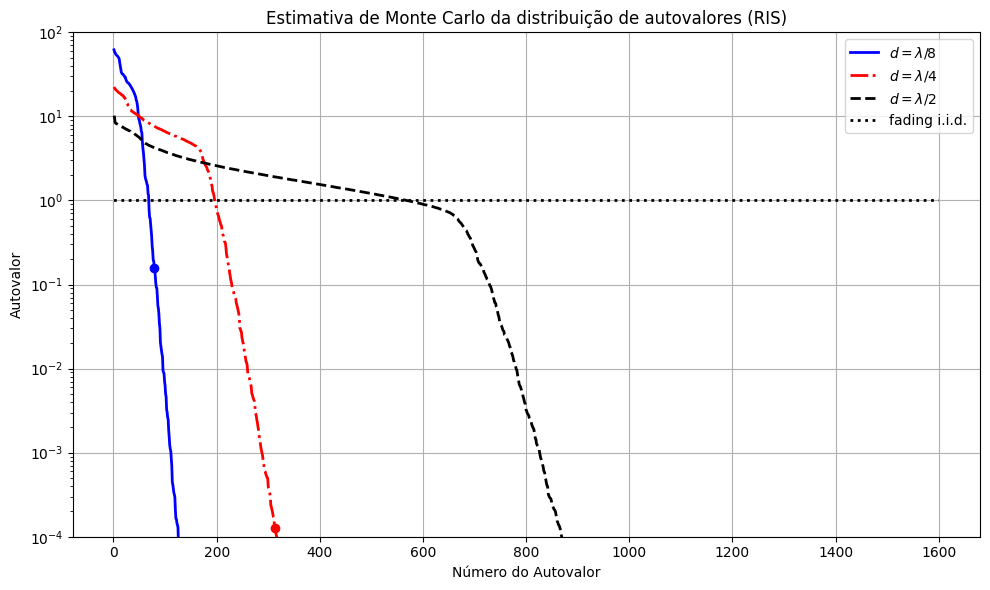

In [13]:
# Simulação de Monte Carlo para estimar a distribuição de autovalores da matriz de correlação espacial
# R para uma Superfície Inteligente Reconfigurável (RIS), com base no artigo:

import numpy as np
import matplotlib.pyplot as plt

# Parâmetros da simulação
lambda_ = 1         # Comprimento de onda
plane_waves = 50    # Número de ondas planas por amostra de Monte Carlo
amostras = 5000     # Número de amostras de Monte Carlo para estimar a matriz de correlação
N_HV = 40           # Número de elementos em cada dimensão do RIS (H (horizontal) e V (vertical))
N = N_HV**2         # Número total de elementos no RIS (40 x 40 = 1600 elementos => RIS é uma grade quadrada)

d_values = [lambda_/8, lambda_/4, lambda_/2]  # Diferentes espaçamentos entre os elementos do RIS

autovalores_R = np.zeros((N, len(d_values)))  # Matriz para armazenar os autovalores estimados para cada valor de 'd'

# Função para amostrar ângulos isotrópicos (phi, theta) na esfera unitária
# Usou-se a EQUAÇÃO (2) do artigo  f (ϕ,θ)= cos(θ)/2π , em que ϕ e θ ∈ [−π/2 , π/2]
def sample_angles(n):
    # Amostra 'n' valores de phi uniformemente entre -pi/2 e pi/2
    # gera n[0,1], o -0,5 leva para [-0,5, 0,5], multiplicado por pi fica [-pi/2, pi/2]
    phi = np.pi * (np.random.rand(n) - 0.5)
    # Amostra 'n' valores de theta de forma que cos(theta) seja uniformemente distribuído entre -1 e 1,
    # a transformada inversa de cos(theta) é arcsin(n), n[0,1], multiplicapo fica [0,2], subtraindo [-1,1]
    theta = np.arcsin(2*np.random.rand(n) - 1)
    return phi, theta

# Loop através dos diferentes valores de espaçamento 'd'
for idx, d in enumerate(d_values):
    # Criação da grade de posições dos elementos do RIS
    gridPoints = np.arange(N_HV) * d  # Coordenadas ao longo de uma dimensão
    X, Y = np.meshgrid(gridPoints, gridPoints)  # Cria a grade 2D de coordenadas x e y
    locations = np.stack((X.flatten(), Y.flatten(), np.zeros(N)), axis=1) # Empilha as coordenadas x e y em um array de posições (x, y, 0) para cada elemento

    # Estimação de Monte Carlo da matriz de correlação R
    # A matriz H armazena os vetores de resposta do canal, que são complexos devido à fase dos sinais recebidos nos elementos do RIS
    H = np.zeros((N, amostras), dtype=complex)  # Matriz para armazenar os vetores de resposta do canal para cada amostra de Monte Carlo

    # Loop através do número de amostras de Monte Carlo
    for s in range(amostras):
        # A resposta do canal é complexa pois tem amplitude e fase
        h = np.zeros(N, dtype=complex)  # Vetor de resposta do canal para uma única amostra de Monte Carlo
        phi, theta = sample_angles(plane_waves)  # Amostra 'plane_waves' pares de ângulos (azimuth e elevação)

        # Loop através do número de ondas planas por amostra
        for l in range(plane_waves):
            # Vetor de onda k para a ésima onda plana. EQUAÇÃO (5) DO ARTIGO
            k = (2*np.pi/lambda_) * np.array([np.cos(theta[l])*np.cos(phi[l]),
                                                np.cos(theta[l])*np.sin(phi[l]),
                                                np.sin(theta[l])
                                                ])
            # Vetor de fase 'a' para a ésima onda plana em todos os elementos do RIS.
            # produto escalar (@) da posição de cada elemento (locations) da RIS e o vetor de onda (k)
            a = np.exp(1j * locations @ k) # EQUAÇÃO (4) DO ARTIGO
            # Contribuição da ésima onda plana para o vetor de resposta do canal 'h'
            # O fator (np.random.randn() + 1j*np.random.randn()) / np.sqrt(2) representa um ganho de canal complexo com média zero e variância unitária.
            # O fator 1 / np.sqrt(L) é para normalizar a potência total das ondas planas.
            # EQUAÇÃO (6) do artigo:
            h += (np.random.randn() + 1j*np.random.randn()) / np.sqrt(2) * a / np.sqrt(plane_waves)

        H[:, s] = h  # Armazena o vetor de resposta do canal para a ésima amostra de Monte Carlo

    # Estima a matriz de correlação R_hat usando a média das amostras de Monte Carlo
    # H contém múltiplas realizações do canal aleatório, ao fazer a multiplicação de matrizes entre H e sua transposta conjugada
    # o resultado é a soma dos produtos externos dos vetores de resposta do canal, que ao dividir esse resultado pelo
    # número total de amostras de Monte Carlo, isso calcula a média dos produtos externos, que é a estimativa de Monte Carlo da matriz de correlação.
    R_hat = (1/amostras) * (H @ H.conj().T)
    # Calcula os autovalores da matriz de correlação estimada, ordena em ordem decrescente e armazena
    autovalores_R[:, idx] = np.sort(np.linalg.eigvalsh(R_hat))[::-1]

# Plotagem dos resultados
plt.figure(figsize=(10, 6))
colors = ['b', 'r', 'k']  # Cores para diferentes espaçamentos
styles = ['-', '-.', '--'] # Estilos de linha para diferentes espaçamentos

# Plota os autovalores para cada valor de espaçamento 'd'
for idx in range(len(d_values)):
    plt.plot(np.arange(1, N+1), autovalores_R[:, idx],
             styles[idx], color=colors[idx], linewidth=2)

# Plota uma linha de referência para o caso de fading i.i.d. (independent and identically distributed)
# onde se assume que os desvanecimentos (variações no sinal) entre diferentes antenas ou elementos
# são estatisticamente independentes e têm a mesma distribuição estatística (Rayleigh).
# Em um canal i.i.d. Rayleigh, a matriz de correlação do canal é uma matriz identidade (ou proporcional a ela).
# Uma matriz identidade tem todos os seus autovalores iguais a 1.
# plt.plot(x, y, especifica k para preto e pontilhado, espessura da linha, rótulo)
plt.plot(np.arange(1, N+1), np.ones(N), 'k:', linewidth=2, label='fading i.i.d.')

# Marca as estimativas do rank para cada espaçamento
# EQUAÇÃO (14) do artigo
for idx, d in enumerate(d_values):
    rank_est = round(np.pi * (N_HV * d)**2)  # Estimativa do rank baseada na área efetiva (Aeff =(N_HV *d)^2) do RIS
    plt.plot(rank_est, autovalores_R[rank_est-1, idx], colors[idx]+'o', linewidth=2)

# o rank de uma matriz é o número de colunas (ou linhas) linearmente independentes
# ou seja, mede quantas direções diferentes de informação uma matriz pode representar.
# No contexto de canais sem fio (MIMO ou RIS), o rank da matriz de correlação espacial indica quantos canais paralelos
# (ou caminhos independentes) o sistema pode explorar. Rank alto → mais diversidade espacial → mais capacidade (mais dados transmitidos simultaneamente).
# Rank baixo → os sinais estão altamente correlacionados → menos efetividade na transmissão paralela.
# O rank efetivo aparece como um ponto destacado (marcado) na curva. Ele mostra até onde os autovalores são relevantes (não desprezíveis).
# É aí que a matriz "deixa de contribuir significativamente" para o canal.

# Plote da correlação espacial da RIS, influenciada pelo espaçamento entre os elementos
# que afeta a distribuição dos autovalores da matriz de correlação do canal.
plt.yscale('log')
plt.ylim([1e-4, 1e2])
plt.xlabel('Número do Autovalor')
plt.ylabel('Autovalor')
plt.legend([r'$d=\lambda/8$', r'$d=\lambda/4$', r'$d=\lambda/2$', 'fading i.i.d.'])
plt.grid(True)
plt.title('Estimativa de Monte Carlo da distribuição de autovalores (RIS)')
plt.tight_layout()
plt.show()
